<a href="https://www.kaggle.com/code/muichimon/rsna-intracranialaneurysm-resnet3d?scriptVersionId=273670027" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **00 - Set Up**

In [1]:
%pip install celluloid --q
%pip install torchio --q

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 M

In [2]:
%matplotlib notebook

from tqdm.notebook import tqdm
from pathlib import Path
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import nibabel as nib
import pydicom

import torch
import torchio as tio 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from celluloid import Camera
from IPython.display import HTML

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
labels = pd.read_csv("/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv")

In [4]:
root_path = Path("/kaggle/input/rsna-intracranial-aneurysm-detection/series/")
patient_dirs = sorted([p for p in root_path.iterdir() if p.is_dir()])

In [5]:
patient_dirs[0]

PosixPath('/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647')

In [6]:
def get_aneurysm_present_for_patient(patient_dir: Path, labels_df: pd.DataFrame):
    """
    Given a patient directory Path (SeriesInstanceUID) and the labels DataFrame,
    return the Aneurysm Present value (0 or 1).
    """
    # Extract SeriesInstanceUID from folder name
    series_uid = patient_dir.name
    
    # Filter DataFrame
    result = labels_df.loc[labels_df["SeriesInstanceUID"] == series_uid, "Aneurysm Present"]
    
    if not result.empty:
        return int(result.values[0])
    else:
        # UID not found
        return None
        

def get_modality_for_patient(patient_dir: Path, labels_df: pd.DataFrame):
    """
    Given a patient directory Path (SeriesInstanceUID) and the labels DataFrame,
    return the Modality value (e.g., 'CT', 'MR', etc.).
    """
    # Extract SeriesInstanceUID from folder name
    series_uid = patient_dir.name
    
    # Filter DataFrame
    result = labels_df.loc[labels_df["SeriesInstanceUID"] == series_uid, "Modality"]
    
    if not result.empty:
        return result.values[0]
    else:
        # UID not found
        return None

In [7]:
for i in range(5):
    status = get_aneurysm_present_for_patient(patient_dirs[i], labels)
    print(status)

0
0
1
0
0


# **01 - DataSet**

## **transforms**

In [8]:
def crop_from_slice(tensor):
    return tensor[..., :30]

In [9]:
process = tio.Compose([
    tio.ToCanonical(),
    tio.Resample((1, 1, 1)),
    tio.RescaleIntensity((-1, 1)),
    tio.Lambda(crop_from_slice),
    tio.CropOrPad((500, 500, 200)),    
])

augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10))

train_transform = tio.Compose([process, augmentation])
val_transform = tio.Compose([process])

## **subject dataset**

In [10]:
class AneurysmSubjectDataset(Dataset):
    """
    Loads full 3D volumes (stacked 2D slices) per patient, along with
    the aneurysm label and modality information.

    Args:
        patient_dirs (list[Path]): list of SeriesInstanceUID directories
        labels_df (pd.DataFrame): dataframe with labels
        train (bool): whether to use train split or validation split
        test_size (float): fraction of data to use as validation
        transform: optional transform function (applied to 3D volume)
        random_state (int): random seed for train/validation split
    """
    def __init__(self, patient_dirs, labels_df, train=True, test_size=0.2, transform=None, random_state=42):
        self.labels_df = labels_df
        self.transform = transform

        # Split into train and validation sets
        train_dirs, val_dirs = train_test_split(
            patient_dirs, test_size=test_size, random_state=random_state, shuffle=True
        )
        self.patient_dirs = train_dirs if train else val_dirs

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_dir = self.patient_dirs[idx]

        # --- Load DICOM slices ---
        dicom_files = list(patient_dir.glob("*.dcm"))
        dicoms = [pydicom.dcmread(f) for f in dicom_files]
        dicoms.sort(key=lambda dcm: int(dcm.InstanceNumber))

        slices = [dcm.pixel_array for dcm in dicoms]

        # Stack into 3D volume: [H, W, D]
        volume = np.stack(slices, axis=-1)  # [H, W, D]
        volume = torch.from_numpy(volume).unsqueeze(0).float()  # [1, H, W, D]
    
        if self.transform:
            import torchio as tio
            subject = tio.Subject(image=tio.ScalarImage(tensor=volume))
            subject = self.transform(subject)
            volume = subject.image.data  # Extract transformed tensor

        # --- Labels and Metadata ---
        label = get_aneurysm_present_for_patient(patient_dir, self.labels_df)
        modality = get_modality_for_patient(patient_dir, self.labels_df)

        label = torch.tensor(label, dtype=torch.long)
        modality = str(modality)  # keep as string, not tensor

        return {
            "image": volume,
            "label": label,
            "modality": modality,
        }

In [11]:
train_dataset = AneurysmSubjectDataset(
    patient_dirs=patient_dirs,
    labels_df=labels,
    train=True,
    test_size=0.5,
    transform=None  
)

val_dataset = AneurysmSubjectDataset(
    patient_dirs=patient_dirs,
    labels_df=labels,
    train=False,
    test_size=0.5,
    transform=None 
)

In [12]:
sample = train_dataset[1]
img = sample["image"]
label = sample["label"]
modal = sample["modality"]

print("Modality:", modal)

Modality: CTA


In [13]:
for i in range(5):
    sample = train_dataset[i]
    img = sample["image"]
    label = sample["label"]
    modal = sample["modality"]

    print("ImgShape:", img.shape)
    print("AneurysmPresent:", label)
    print("Modality:", modal)

ImgShape: torch.Size([1, 512, 512, 40])
AneurysmPresent: tensor(1)
Modality: CTA
ImgShape: torch.Size([1, 512, 512, 886])
AneurysmPresent: tensor(1)
Modality: CTA
ImgShape: torch.Size([1, 512, 512, 140])
AneurysmPresent: tensor(1)
Modality: MRA
ImgShape: torch.Size([1, 512, 512, 280])
AneurysmPresent: tensor(0)
Modality: MRA
ImgShape: torch.Size([1, 320, 280, 45])
AneurysmPresent: tensor(0)
Modality: MRI T2


In [14]:
print(len(train_dataset), len(val_dataset))

2174 2174


## **visualize**

ImgShape: torch.Size([1, 512, 512, 886])
AneurysmPresent: tensor(1)
Modality: CTA


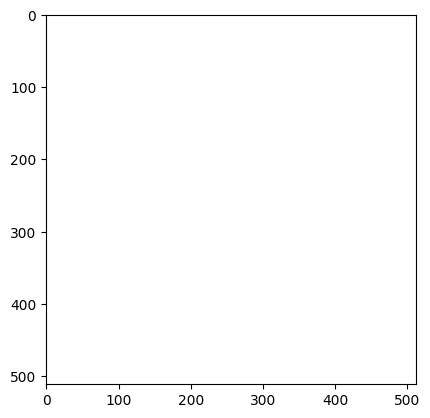

In [15]:
fig = plt.figure()
camera = Camera(fig)

sample = train_dataset[1]
img = sample["image"]
label = sample["label"]
modal = sample["modality"]

print("ImgShape:", img.shape)
print("AneurysmPresent:", label)
print("Modality:", modal)

for i in range(img.shape[3]): 
    plt.imshow(img[0, :, :, i], cmap="bone")
    camera.snap();

animation = camera.animate(interval=50);
HTML(animation.to_html5_video())